# Baseline model: Decision Tree Regressor

### 1. Prepare data set as DF

In [26]:
# imports 
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor 


import matplotlib.pyplot as plt


# Load datasets
train_df = pd.read_csv("data/train.csv")
test_df  = pd.read_csv("data/test.csv")

# Drop columns with no variance (from EDA)
drop_cols = ['X11','X93','X107','X233','X235','X268','X289','X290','X293','X297','X330','X347']
train_df = train_df.drop(columns=drop_cols, errors="ignore")
test_df  = test_df.drop(columns=drop_cols, errors="ignore")

# 3) One-Hot Encode categorical columns
categorical_cols = ['X0','X1','X2','X3','X4','X5','X6','X8']
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform='pandas')

# Ohe on train categoricals
ohe_train = ohe.fit_transform(train_df[categorical_cols])
# Ohe on test categoricals
ohe_test  = ohe.transform(test_df[categorical_cols])

# Transformed dataframes (drop original categoricals, join OHE)
train_transformed = train_df.drop(columns=categorical_cols).join(ohe_train)
test_transformed  = test_df.drop(columns=categorical_cols).join(ohe_test)

# Quick checks
print("Shapes")
print("Original train_df shape:    ", train_df.shape)
print("Transformed train_df shape: ", train_transformed.shape)

print("\n Dropped Categorical Columns")
print(categorical_cols)

print("\n New OHE Columns Names")
print(ohe.get_feature_names_out(categorical_cols)[:20])  # show first 20 OHE columns
print(f"Total new OHE columns: {len(ohe.get_feature_names_out(categorical_cols))}")

Shapes
Original train_df shape:     (4209, 366)
Transformed train_df shape:  (4209, 553)

 Dropped Categorical Columns
['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8']

 New OHE Columns Names
['X0_a' 'X0_aa' 'X0_ab' 'X0_ac' 'X0_ad' 'X0_af' 'X0_ai' 'X0_aj' 'X0_ak'
 'X0_al' 'X0_am' 'X0_ao' 'X0_ap' 'X0_aq' 'X0_as' 'X0_at' 'X0_au' 'X0_aw'
 'X0_ax' 'X0_ay']
Total new OHE columns: 195


### 2. Train the Model

In [19]:

#Define X and y 
feature_cols = [c for c in train_transformed.columns if c not in ['ID', 'y']]
X = train_transformed[feature_cols]
y = train_transformed['y']

# Train-Test split
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.20, random_state=42
)

print("Train/valid shapes ->",
      "X_train:", X_train.shape, " X_valid:", X_valid.shape)

Train/valid shapes -> X_train: (3367, 551)  X_valid: (842, 551)


### 3. Baseline desicion tree (no tuning)
 - No scaling needed for trees
- This is our simplest non-linear baseline

In [20]:
tree = DecisionTreeRegressor(random_state=42)  # defaults: can overfit; we'll see baseline
tree.fit(X_train, y_train)

#Evaluation (RMSE, R^2) on the validation split

y_pred = tree.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
r2   = r2_score(y_valid, y_pred)

print("\nDecision Tree Regressor — Baseline")
print(f"RMSE: {rmse:.3f}")  # average error in seconds
print(f"R²:   {r2:.3f}")    # variance explained

# feature importance (optional)
importances = pd.Series(tree.feature_importances_, index=feature_cols)
top_imp = importances.sort_values(ascending=False).head(15)
print("\nTop 15 Feature Importances:")
print(top_imp)


Decision Tree Regressor — Baseline
RMSE: 12.478
R²:   -0.000

Top 15 Feature Importances:
X314    0.365371
X315    0.077554
X263    0.066144
X119    0.057383
X156    0.032620
X8_t    0.027922
X6_i    0.007898
X6_d    0.007876
X5_n    0.007052
X5_q    0.006888
X47     0.006093
X5_r    0.006022
X6_g    0.005870
X136    0.005816
X231    0.005567
dtype: float64


## Conclusions Decision Tree regressor NO tuning

**RMSE: 12.478** On average, predictions are off by ~12.5 seconds.
-This is worse than baselines with Linear Regression (Top-3 RMSE ≈ 9.6, Top-10 RMSE ≈ 8.3, Ridge RMSE ≈ 8.2)

**R²: -0.000** Negative R² means the model performed no better than just predicting the mean of y. Very possible overfiting.

**Feature Importances** The most useful splits came from: 
- X314 (36%),
-  X315 (7.8%),
- X263 (6.6%),
- X119 (5.7%),
- X156 (3.3%),
- some categorical OHE features (X8_t, X6_i, X5_n, …).

- These features are in line with results of correlation analysis — ex = X314, X263, X136...
- The modle is choosing X314 (dominates)

Conclusions of baseline tree: 
- This is expected: a single tree overfits by default
- Its poor generalization (R² ≈ 0) confirms why trees are rarely used alone in practice
- The feature importance is still useful — it highlights strong signals in the data

## 4. Tuning Decision tree regressor

In [21]:
# Create a regularized tree
tree_tuned = DecisionTreeRegressor(
    random_state=42,
    max_depth=10,        # limit tree depth to prevent overfitting
    min_samples_split=10, # require at least 10 samples to split a node
    min_samples_leaf=5    # each leaf must have at least 5 samples
)

# Fit tuned model
tree_tuned.fit(X_train, y_train)

# Predict on validation split
y_pred_tuned = tree_tuned.predict(X_valid)

# Evaluate
rmse_tuned = np.sqrt(mean_squared_error(y_valid, y_pred_tuned))
r2_tuned   = r2_score(y_valid, y_pred_tuned)

print("\nDecision Tree Regressor — Tuned")
print(f"RMSE: {rmse_tuned:.3f}")
print(f"R²:   {r2_tuned:.3f}")

# Feature importance (optional)
importances_tuned = pd.Series(tree_tuned.feature_importances_, index=feature_cols)
top_imp_tuned = importances_tuned.sort_values(ascending=False).head(15)
print("\nTop 15 Feature Importances (Tuned Tree):")
print(top_imp_tuned)


Decision Tree Regressor — Tuned
RMSE: 8.612
R²:   0.523

Top 15 Feature Importances (Tuned Tree):
X314    0.576160
X315    0.122297
X263    0.104304
X118    0.089910
X115    0.010380
X142    0.009786
X47     0.008408
X354    0.007173
X2_s    0.005500
X85     0.004968
X3_c    0.002577
X267    0.002422
X349    0.002409
X152    0.002372
X179    0.002344
dtype: float64


## Conclusions after Tuning 

**RMSE: 8.612**  improvement from the untuned baseline (12.478).

- Now predictions are, on average, only ~8.6 seconds off.
- This is in the same Top-10 Linear Regression (8.3) and Ridge (8.2).
- Tuning fixed the overfitting issue.

**R²: 0.523**
- Now the tree explains ~52% of the variance in y. Much better than the baseline (≈ 0)
- Comparable to Top-10 Linear Regression (0.557) and Ridge (0.566)
**Tuned tree is competitive with our best linear model (Ridge)**

**Feature Importances**

- X314 (57%), X315 (12%), X263 (10%), X118 (9%) dominate (confirms EDA)
- Compared to the untuned tree (X314 = 36%) going more to stronger predictors 
- several low importances (0.2–0.5%) tree is ingnoring noise

**Conclusions**
- A single, tuned tree is already a strong non-linear competitor to Ridge model (linear model)
- The tuned tree has similar RMSE/R² as Ridge, but with a different modeling approach
- Radom forrest is necesary to have more control over performance (many tunned trees).trees are sensitive to changes in slplit/seed 

# Random Forest Regressor

## Basline Model for random forrest regressor

In [22]:
# Create model 
# - n_estimators: number of trees (100 is default, 200 stil fast and more stable)
# - n_jobs=-1: use all CPU cores ?
rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

# Fit on training data
rf.fit(X_train, y_train)

# Predict on testing data (validation split)
y_pred_rf = rf.predict(X_valid)

# Evaluate
rmse_rf = np.sqrt(mean_squared_error(y_valid, y_pred_rf))
r2_rf   = r2_score(y_valid, y_pred_rf)

print("\nRandom Forest Regressor — Baseline")
print(f"RMSE: {rmse_rf:.3f}")
print(f"R²:   {r2_rf:.3f}")

# (Optional) Feature importance — average across trees
importances_rf = pd.Series(rf.feature_importances_, index=X_train.columns)
print("\nTop 15 Feature Importances (Random Forest):")
print(importances_rf.sort_values(ascending=False).head(15))



Random Forest Regressor — Baseline
RMSE: 9.121
R²:   0.465

Top 15 Feature Importances (Random Forest):
X314     0.362296
X315     0.059009
X118     0.030221
X119     0.028045
X5_ag    0.026990
X263     0.024343
X8_t     0.015861
X136     0.015160
X127     0.014599
X5_q     0.008418
X6_g     0.007754
X29      0.006955
X5_ab    0.006449
X279     0.006249
X47      0.006170
dtype: float64


## Conclusions of baseline model for random forrest

**RMSE: 9.121**  Predictions are off by about 9.1 seconds on average
- Better than untuned tree (12.5), but worse than a tuned single tree (8.6), Ridge (8.2), and Top-10 Linear (8.3)
- This baseline is not tuned so is overfiting (no depth limits, no leaf constraints) 

**R²: 0.465** The model explains ~46.5% of the variance
- Worse than tuned single tree (52%) and Ridge (57%)

**Feature Importances**

**X314 (36%)** ominating. onsistent across all models.

**Secondary features:** X315, X118, X119, X263, X136 — Also in correlation & tuned tree importances

**New Important features** OHE features like X5_ag, X8_t Shows the forest is considering more variables than regression

**Conclusion**
- The baseline forest is better than untuned single tree, but not better than the tuned tree or Ridge
- Why: Random forests need regularization (max_depth, min_samples_leaf, max_features) to stabilize performance
- Default RF settings can overfit (no generalization)

## Tuned Random Forest 
We add hyperparameter tuninig to control overfiting 

- max_depth=10: controls complexity
- min_samples_split=10 & min_samples_leaf=5: prevents small leaves that catch noise
- max_features='sqrt': classic RF setting? forces trees to see different subsets of features: better generalization
- n_estimators=200: enough trees for stability without being too slow

In [25]:
rf_tuned = RandomForestRegressor(
    n_estimators=300,
    max_depth=12,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features=0.5,   # best performing variant
    random_state=42,
    n_jobs=-1
)

# Fit tuned model
rf_tuned.fit(X_train, y_train)

# Predict on validation
y_pred_rf_tuned = rf_tuned.predict(X_valid)

# Evaluate
rmse_rf_tuned = np.sqrt(mean_squared_error(y_valid, y_pred_rf_tuned))
r2_rf_tuned   = r2_score(y_valid, y_pred_rf_tuned)

print("\nRandom Forest Regressor — Tuned Final")
print(f"RMSE: {rmse_rf_tuned:.3f}")
print(f"R²:   {r2_rf_tuned:.3f}")
    
    



Random Forest Regressor — Tuned Final
RMSE: 8.056
R²:   0.583


## Feature Importance Tuned Random Forest


Top 15 Feature Importances (Tuned Random Forest):
X314    0.285426
X261    0.137273
X127    0.118818
X263    0.046971
X315    0.045800
X119    0.038869
X118    0.028474
X279    0.027572
X29     0.021233
X232    0.019040
X136    0.013448
X115    0.011190
X76     0.010179
X47     0.006603
X54     0.004843
dtype: float64


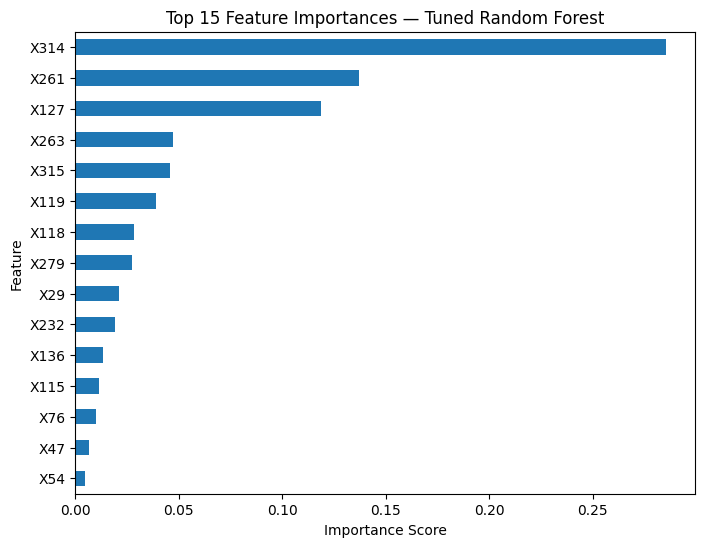

In [27]:
importances_rf = pd.Series(rf_tuned.feature_importances_, index=X_train.columns)
top_features = importances_rf.sort_values(ascending=False).head(15)

print("\nTop 15 Feature Importances (Tuned Random Forest):")
print(top_features)

# Bar plot 
plt.figure(figsize=(8,6))
top_features.sort_values().plot(kind='barh')
plt.title("Top 15 Feature Importances — Tuned Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


## Conclusions Tuned Random Forest
** Baseline Random Forest**
- RMSE ≈ 9.12, R² ≈ 0.465: Worse than Ridge and tuned single tree.

**Tuned Random Forest**
- sqrt → RMSE 8.167, R² 0.571

- 0.5 → RMSE 8.056, R² 0.583

- 0.3 → RMSE 8.057, R² 0.583

**Conclusions**

- After tuning, the Random Forest is better than all linear models (Top-10 Regression, Ridge) and than a tuned single tree

- **RMSE ~ 8.05 (best so far), R² ~ 0.58 (highest variance explained)** 


# TUNED RANDOM FORREST IS THE BEST MODEL FOR THE MERCEDES DATA SET